In [6]:
# from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.messages import SystemMessage
# from langchain.messages import ToolMessage
from typing import Literal, List

from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.messages import HumanMessage, AIMessage
from langchain_core.retrievers import BaseRetriever

In [2]:
# 샘플 문서 데이터
documents = [
    "인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습하고 추론할 수 있도록 하는 기술입니다.",
    "머신러닝은 AI의 한 분야로, 데이터로부터 패턴을 학습하여 예측이나 분류를 수행합니다.",
    "딥러닝은 신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 하위 분야입니다.",
    "자연어처리(NLP)는 인간의 언어를 컴퓨터가 이해하고 처리할 수 있도록 하는 AI 기술입니다.",
    "컴퓨터 비전은 이미지나 비디오에서 의미 있는 정보를 추출하는 AI 분야입니다."
]

# Document 객체로 변환
docs = [Document(page_content=text) for text in documents]

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50
)
splits = text_splitter.split_documents(docs)

In [3]:
embeddings = HuggingFaceEndpointEmbeddings(client="http://127.0.0.1:8080/")
vectorstore = InMemoryVectorStore.from_documents(splits, embeddings)

In [4]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [7]:
model = init_chat_model(
    "smollm2",
    model_provider="ollama",
    base_url="http://localhost:11434",
    temperature=0,
    max_tokens=50,
    model_kwargs={
    "num_predict": 50  # Ollama 전용 파라미터
    }
)


In [8]:
def retriever_call(state: dict):  
    retriever = vectorstore.as_retriever(
        search_type="similarity",  # "similarity_score_threshold" 대신
        search_kwargs={"k": 2}  # score_threshold 대신 k 사용
    )
    return {
        "retriever": retriever
    }

In [ ]:
def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="아래 문장의 의도를 한 문장으로 간결하게 파악해 주세요. 불필요한 설명 없이 의도만 명확하게 답변하세요.\n\n문장: \"{문장}\""
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [ ]:
#  content="당신은 감정 분석 전문가입니다. 문장의 감정을 분석하여 반드시 '긍정' 또는 '부정' 중 하나만 답변하세요. 추가 설명 없이 감정만 판단하세요"
# content="당신은 키워드 추출 전문가입니다. 주어진 문장에서 핵심 키워드만 뽑아 한글 쉼표(,)로 구분하여 나열하세요. 불필요한 설명 없이 키워드만 답변하세요."

In [10]:
graph = StateGraph(MessagesState)
graph.add_node(llm_call)
graph.add_node(retriever_call)
graph.add_edge(START, "retriever_call")
graph.add_edge("retriever_call", "llm_call")
graph.add_edge("llm_call", END)
graph = graph.compile()

In [11]:
graph.invoke({"messages": [{"role": "user", "content": "오늘 날씨가 좋아요."}]})

{'messages': [HumanMessage(content='오늘 날씨가 좋아요.', additional_kwargs={}, response_metadata={}, id='e6d65690-baf7-4764-a3ed-9726b7f8a28a'),
  AIMessage(content='The weather is nice today.', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-08T12:28:22.710606987Z', 'done': True, 'done_reason': 'stop', 'total_duration': 11538458708, 'load_duration': 4532664090, 'prompt_eval_count': 178, 'prompt_eval_duration': 4901416000, 'eval_count': 7, 'eval_duration': 2094833471, 'logprobs': None, 'model_name': 'smollm2', 'model_provider': 'ollama'}, id='lc_run--88f1e8af-67ae-4618-9b5e-a3b4fadddd97-0', usage_metadata={'input_tokens': 178, 'output_tokens': 7, 'total_tokens': 185})]}

In [12]:
graph.invoke({"messages": [{"role": "user", "content": "컴퓨터 비전에 대해 알려줘"}]})

{'messages': [HumanMessage(content='컴퓨터 비전에 대해 알려줘', additional_kwargs={}, response_metadata={}, id='fbe7a5c0-9a2f-43bf-b160-3f41c7d8a908'),
  AIMessage(content='Computer graphics', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-08T12:28:24.061307869Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1324928162, 'load_duration': 36680102, 'prompt_eval_count': 185, 'prompt_eval_duration': 988176536, 'eval_count': 3, 'eval_duration': 294860548, 'logprobs': None, 'model_name': 'smollm2', 'model_provider': 'ollama'}, id='lc_run--afea1bb7-6bcf-4a4c-980a-69e76e1667cb-0', usage_metadata={'input_tokens': 185, 'output_tokens': 3, 'total_tokens': 188})]}

In [ ]:
# 키워드 추출, 감정 분석, 코딩 등 활용 고려

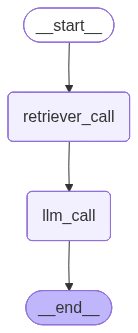

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))